<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from pprint import pprint
import glob
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
import skimage.morphology

import run_tissuecyte_stitching_classic

In [2]:
def load_image(image_path):
    image = sitk.ReadImage(str(image_path))
    image = sitk.GetArrayFromImage(image)
    image[image<0] = 0
    image = image.T
    #image = np.flip(image,axis=1)
    #image = np.flip(image,axis=2)
    image = np.squeeze(image)
    return image

def preprocess(img: np.ndarray, min_val: float = None, max_val: float = 400) -> np.ndarray:
    """
    FOR VISUALIZATION PURPOSES
    Preprocesses volume data. Clips maximum value at max_val and then normalizes volume
    between 0-255.
    """
    data = img.copy()
    data[data > max_val] = max_val
    if min_val:
        data[data < min_val] = min_val
    data = cv2.normalize(src=data, dst=None, alpha=0, beta=255, 
                         norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    return data

def auto_contrast(data: np.ndarray, alpha: float = None, beta: float = None) -> np.ndarray:
    """
    Preprocess tiff files to automatically adjust brightness and contrast.
    https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape
    """
    if not alpha:
        alpha = np.iinfo(data.dtype).max / (np.max(data) - np.min(data))
    if not beta:
        beta = -np.min(data) * alpha
    img = cv2.convertScaleAbs(data, alpha=alpha, beta=beta)
    return img

def adjust_average_tiles(tiles: np.ndarray, multiplier=1.0) -> np.ndarray:
    """
    Adjusts the average tiles to be a different value based on a multiplier.
    """
    return tiles.copy() * multiplier

## Load data

In [3]:
# Input folder parameters
tile_folder = "../B0070/tiles/"
#average_folder = "../B0070/stitched_avg_all_tiles/avg_tiles/"
average_folder = "../B0070/stitched_median_mask/avg_tiles/"

# Get relevant paths
average_paths = glob.glob(average_folder + "/*.tif")
tile_paths = glob.glob(tile_folder + "/*/")
print("Average tiles:")
pprint(average_paths)
print("\nTile folders:")
pprint(tile_paths)

# Generate starting info
print("Creating stitching JSON for sections")
root_dir = tile_folder
depth = 1
sectionNum = 0
mosaic_data, section_jsons = run_tissuecyte_stitching_classic.get_section_data(root_dir, depth, sectionNum)
average_tiles = np.array([run_tissuecyte_stitching_classic.load_average_tile(p) for p in average_paths])
print("Average tiles shape:", average_tiles.shape)

Average tiles:
[]

Tile folders:
['../B0070/tiles\\231023_B0070_MR-0001\\',
 '../B0070/tiles\\231023_B0070_MR-0002\\',
 '../B0070/tiles\\231023_B0070_MR-0003\\',
 '../B0070/tiles\\231023_B0070_MR-0004\\',
 '../B0070/tiles\\231023_B0070_MR-0005\\',
 '../B0070/tiles\\231023_B0070_MR-0006\\',
 '../B0070/tiles\\231023_B0070_MR-0007\\',
 '../B0070/tiles\\231023_B0070_MR-0008\\',
 '../B0070/tiles\\231023_B0070_MR-0009\\',
 '../B0070/tiles\\231023_B0070_MR-0010\\',
 '../B0070/tiles\\231023_B0070_MR-0011\\',
 '../B0070/tiles\\231023_B0070_MR-0012\\',
 '../B0070/tiles\\231023_B0070_MR-0013\\',
 '../B0070/tiles\\231023_B0070_MR-0014\\',
 '../B0070/tiles\\231023_B0070_MR-0015\\',
 '../B0070/tiles\\231023_B0070_MR-0016\\',
 '../B0070/tiles\\231023_B0070_MR-0017\\',
 '../B0070/tiles\\231023_B0070_MR-0018\\',
 '../B0070/tiles\\231023_B0070_MR-0019\\',
 '../B0070/tiles\\231023_B0070_MR-0020\\',
 '../B0070/tiles\\231023_B0070_MR-0021\\',
 '../B0070/tiles\\231023_B0070_MR-0022\\',
 '../B0070/tiles\\231

In [4]:
# Show average tiles
print("Average tile ch0 mean:", np.mean(average_tiles[0]))
print("Average tile ch0 median:", np.median(average_tiles[0]))
print("Average tile ch0 min:", np.min(average_tiles[0]))
print("Average tile ch0 max:", np.max(average_tiles[0]))

plt.title("Average tile ch0")
plt.imshow(average_tiles[0], cmap="viridis")
plt.show()

avg0_prepreprocessed = preprocess(average_tiles[0], 0, 255) * 100
plt.title("Preprocessed ch0")
plt.imshow(avg0_prepreprocessed, cmap="viridis")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
# Try stitching a single tile
stitch_index = 129
multiplier = 1.0
output_dir = "output/"

# Check if directory exists and create it if it doesn't exist
if not os.path.exists(output_dir + "/stitched_ch0/"):
    os.makedirs(output_dir + "/stitched_ch0/")
if not os.path.exists(output_dir + "/stitched_ch1/"):
    os.makedirs(output_dir + "/stitched_ch1/")
if not os.path.exists(output_dir + "/stitched_ch2/"):
    os.makedirs(output_dir + "/stitched_ch2/")
if not os.path.exists(output_dir + "/stitched_ch3/"):
    os.makedirs(output_dir + "/stitched_ch3/")

# Stitching parameters
curr_section = section_jsons[stitch_index]
save_undistorted = False

# Adjust average tiles
#average_tiles = adjust_average_tiles(average_tiles, multiplier)
#average_tiles[average_tiles != -9999] = 1.0

#average_paths = glob.glob("../B0013/stitched/avg_tiles/" + "/*.tif")
#average_tiles = np.array([run_tissuecyte_stitching_classic.load_average_tile(p) for p in average_paths])


run_tissuecyte_stitching_classic.stitch_section(curr_section, average_tiles, output_dir, save_undistorted)

INFO:root:image_dimensions: {'row': 11236, 'column': 8716}


IndexError: index 0 is out of bounds for axis 0 with size 0

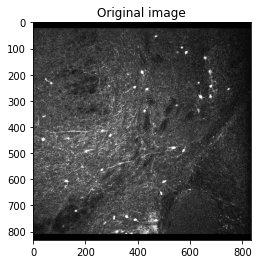

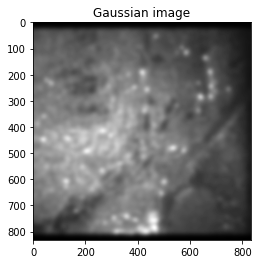

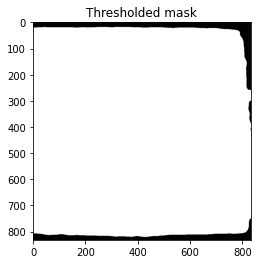

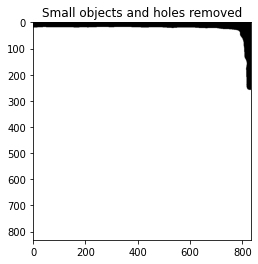

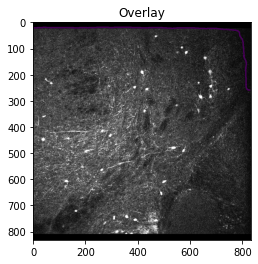

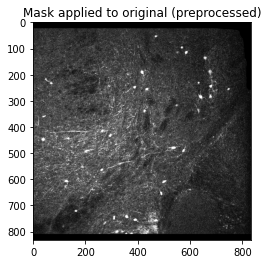

In [199]:
# Tile samples
black_tile1 = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9090_02.tif"
black_tile2 = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9092_02.tif"
partial_tile1 = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9118_01.tif"
partial_tile2 = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9119_01.tif"
full_tile1 = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9137_01.tif"
full_tile2 = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9150_01.tif"

# Load image
img = load_image(full_tile2)
y, x = img.shape

# Settings
gauss_kernel = 55
thresh = 15
min_size = max(64, int(max(y, x) * 0.20))
area_threshold = max(64, int(max(y, x) * 20))

# Preprocess image
mask = img.copy()
mask = preprocess(mask, min_val=0, max_val=400)
orig = mask.copy()
mask = cv2.GaussianBlur(mask, (gauss_kernel, gauss_kernel), 0)

plt.imshow(orig, cmap='gray')
plt.title("Original image")
plt.show()

plt.imshow(mask, cmap='gray')
plt.title("Gaussian image")
plt.show()

# Apply morphological operations
"""
morph = mask.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
plt.imshow(morph, cmap='gray')
plt.title('Morphological operations')
plt.show()
"""

# Threshold it
mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1].astype(bool)
#mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1].astype(bool)
mask = np.where(mask > 0, 1, 0).astype(bool)
plt.imshow(mask, cmap='gray')
plt.title('Thresholded mask')
plt.show()


# Remove small specks from background
mask = skimage.morphology.remove_small_objects(mask.astype(bool), min_size=min_size).astype(bool)
mask = skimage.morphology.remove_small_holes(mask, area_threshold=area_threshold).astype(bool)
plt.imshow(mask, cmap='gray')
plt.title('Small objects and holes removed')
plt.show()

plt.imshow(orig, cmap='gray')
plt.contour(mask)
plt.title('Overlay')
plt.show()

# Apply mask to image
masked_img = np.where(mask, img, 0)
masked_img_preprocessed = preprocess(masked_img, min_val=0, max_val=400)
plt.imshow(masked_img_preprocessed, cmap='gray')
plt.title('Mask applied to original (preprocessed)')
plt.show()

## Visualize stitched sections

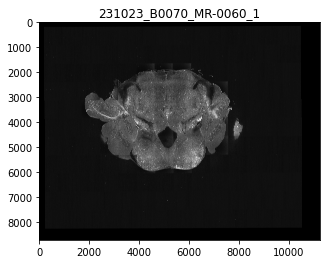

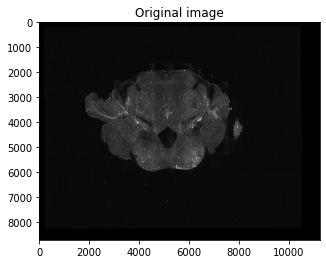

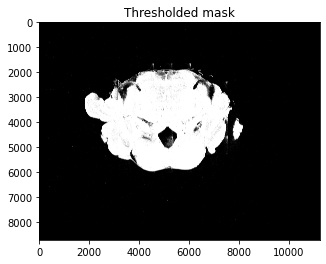

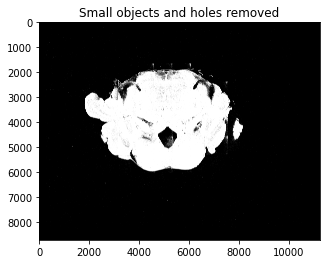

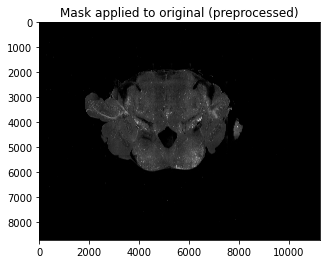

In [62]:
# Median 20 with no application on black tiles
channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()


y, x = output_tile.shape

# Settings
thresh = 25
min_size = max(64, int(max(y, x) * 0.20))
area_threshold = max(64, int(max(y, x) * 20))

# Preprocess image
mask = output_tile.copy()
mask = preprocess(mask, min_val=0, max_val=400)
plt.imshow(mask, cmap='gray')
plt.title("Original image")
plt.show()

# Threshold it
mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1].astype(bool)
#mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1].astype(bool)
mask = np.where(mask > 0, 1, 0).astype(bool)
plt.imshow(mask, cmap='gray')
plt.title('Thresholded mask')
plt.show()


# Remove small specks from background
mask = skimage.morphology.remove_small_objects(mask.astype(bool), min_size=2).astype(bool)
#mask = skimage.morphology.remove_small_holes(mask, area_threshold=area_threshold).astype(bool)
plt.imshow(mask, cmap='gray')
plt.title('Small objects and holes removed')
plt.show()

# Apply mask to image
masked_img = np.where(mask, output_tile, 0)
masked_img_preprocessed = preprocess(masked_img, min_val=0, max_val=400)
plt.imshow(masked_img_preprocessed, cmap='gray')
plt.title('Mask applied to original (preprocessed)')
plt.show()

## Visualize sample tiles

Mean: 12.3027849366679
Median: 14.0
Min: 0
Max: 49


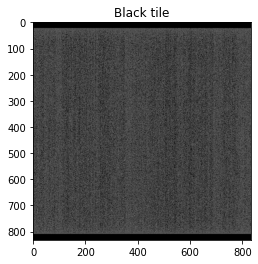

In [12]:
# Black tile
black_tile = "../B0013/2304076_Brain/230406_Brain0013_PG_trap2xAi9_black1-0040/04062023-1647-6105_04.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=3.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 348.6547273714867
Median: 153.0
Min: 0
Max: 24097


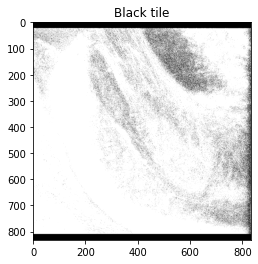

In [20]:
# Black tile
black_tile = "../B0013/2304076_Brain/230406_Brain0013_PG_trap2xAi9_black1-0053/04062023-1647-8069_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=3.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

B0070

Mean: 17.27208100268121
Median: 18.0
Min: 0
Max: 547


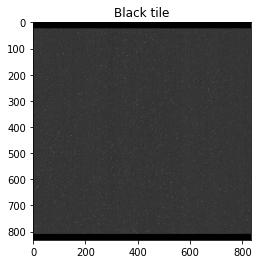

In [6]:
# Black tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9092_02.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=3.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 17.229801335983726
Median: 18.0
Min: 0
Max: 6121


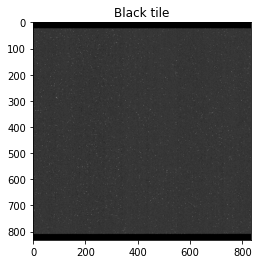

In [7]:
# Black tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9090_02.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=3.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 17.653092062684912
Median: 16.0
Min: 0
Max: 1710


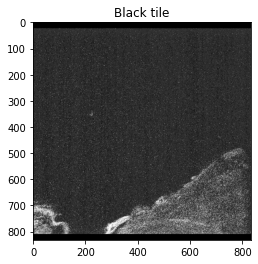

In [8]:
# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9118_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=3.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 43.408038438424555
Median: 20.0
Min: 0
Max: 4457


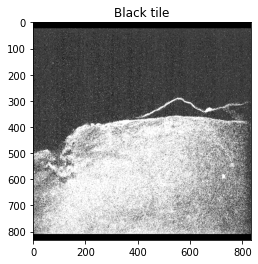

In [ ]:
# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9119_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 54.30651060928255
Median: 42.0
Min: 0
Max: 21967


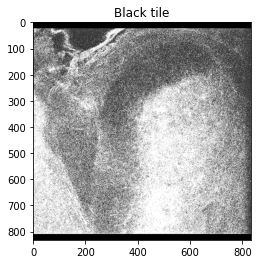

In [ ]:
# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9137_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 96.9022686298077
Median: 83.0
Min: 0
Max: 7996


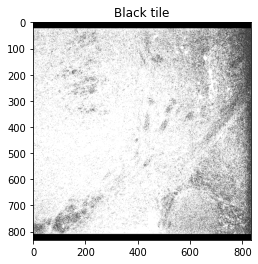

In [ ]:
# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9150_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Show all sections

In [ ]:
# Section paths
#section_paths = glob.glob("../B0070/stitched_avg_all_tiles/stitched_ch0/*.tif")

# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/*.tif"
expaths = glob.glob(black_tile)
for p in expaths:
    curr_tile = load_image(p)

    # Modify the tile for visualization
    curr_tile = auto_contrast(curr_tile, alpha=4.0)
    plt.title(p)
    plt.imshow(curr_tile, cmap="gray")
    plt.show()